In [1]:
import os

import numpy as np
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_env
from utils import decision_policy, update_terminal_reward, policy_reval, softmax
from utils_render import plot_decision_prob
from models import SR_IS, SR_TD

In [2]:
# Hyperparams
reward = -0.1
alpha = 0.05
beta = 1.0
num_steps = 150000
num_iterations = 10
old_reward = 10
new_reward = 20
env = "maze-10x10-two-goal"

# For plotting
colors = [1, 9]

# Save dir
save_dir = os.path.join('..', 'figures/')

## Policy Revaluation

### Complete Model

In [6]:
prob_old_complete, prob_new_complete = [[], []], [[], []]

for i in range(num_iterations):
    print(f"Iteration: {i+1}")
    np.random.seed(i)
    linear_rl = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=True)
    update_terminal_reward(linear_rl, loc=0, r=old_reward)

    D_inv = linear_rl.get_D_inv() * linear_rl.gamma
    linear_rl.DR = D_inv
    linear_rl.update_V()
    pii_old_complete = decision_policy(linear_rl, linear_rl.Z)

    update_terminal_reward(linear_rl, loc=1, r=new_reward)

    V_new, Z_new = policy_reval(linear_rl)
    pii_new_complete = decision_policy(linear_rl, Z_new)

    prob_old_complete[0].append(pii_old_complete[28,23])
    prob_old_complete[1].append(pii_old_complete[28,34])
    prob_new_complete[0].append(pii_new_complete[28,23])
    prob_new_complete[1].append(pii_new_complete[28,34])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


### TD Models

In [4]:
prob_old_sr_is, prob_new_sr_is = [[], []], [[], []]
prob_old_sr_mb, prob_new_sr_mb = [[], []], [[], []]

for i in range(num_iterations):
    print(f"Iteration {i+1}")
    np.random.seed(i)
    sr_is = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=True)
    # sr = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
    #               num_steps=num_steps, policy="softmax", imp_samp=False)
    sr_mb = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=False)

    update_terminal_reward(sr_is, loc=0, r=old_reward)
    # update_terminal_reward(sr, loc=0, r=5)
    update_terminal_reward(sr_mb, loc=0, r=old_reward)

    ## Learn current terminal reward structure and get current policy
    sr_is.learn(seed=int(i))
    sr_mb.learn(seed=int(i))

    pii_old_sr_is = decision_policy(sr_is, sr_is.Z)
    pii_old_sr = decision_policy(sr_mb, sr_mb.Z)

    ## Update terminal states and get new policy
    # SR-IS
    update_terminal_reward(sr_is, loc=1, r=new_reward)
    V_new, Z_new = policy_reval(sr_is)
    pii_new_sr_is = decision_policy(sr_is, Z_new)

    prob_old_sr_is[0].append(pii_old_sr_is[28,23])
    prob_old_sr_is[1].append(pii_old_sr_is[28,34])
    prob_new_sr_is[0].append(pii_new_sr_is[28,23])
    prob_new_sr_is[1].append(pii_new_sr_is[28,34])

    # SR-MB
    sr_mb_r_old = np.full_like(sr_mb.r, fill_value=0)
    sr_mb_r_old[4] = old_reward
    sr_mb_r_new = np.copy(sr_mb_r_old)
    sr_mb_r_new[56] = new_reward
    

    I = np.eye(sr_mb.size)
    SR_Inv = np.linalg.inv(I-sr_mb.gamma*pii_old_sr)

    V_old = SR_Inv @ sr_mb_r_old
    V_new = SR_Inv @ sr_mb_r_new

    probs_old_sr_mb = softmax(x=np.array([V_old[23], V_old[34]]), temperature=1)
    probs_new_sr_mb = softmax(x=np.array([V_new[23], V_new[34]]), temperature=1)
    prob_old_sr_mb[0].append(probs_old_sr_mb[0])
    prob_old_sr_mb[1].append(probs_old_sr_mb[1])
    prob_new_sr_mb[0].append(probs_new_sr_mb[0])
    prob_new_sr_mb[1].append(probs_new_sr_mb[1])

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


### Plot decision probs at key point

#### Complete Model

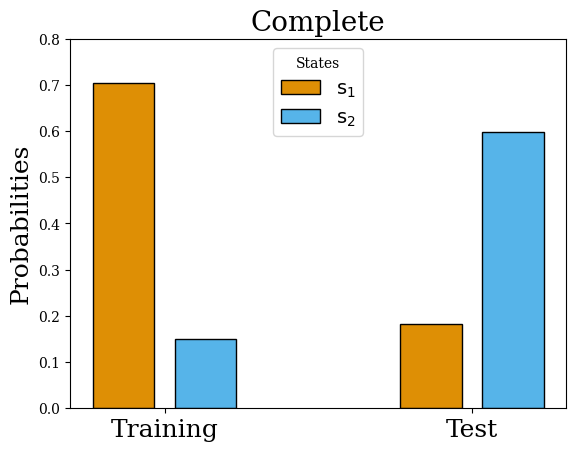

In [8]:
save_path = save_dir + 'policy_reval_complete.png'

prob_train_mean = [np.mean(prob_old_complete[0]), np.mean(prob_old_complete[1])]
prob_test_mean = [np.mean(prob_new_complete[0]), np.mean(prob_new_complete[1])]
std_train = [sem(prob_old_complete[0]), sem(prob_old_complete[1])]
std_test = [sem(prob_new_complete[0]), sem(prob_new_complete[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='Complete',
    leg_loc="upper center",
    save_path=save_path,
    std=[std_train, std_test]
)

#### SR-IS

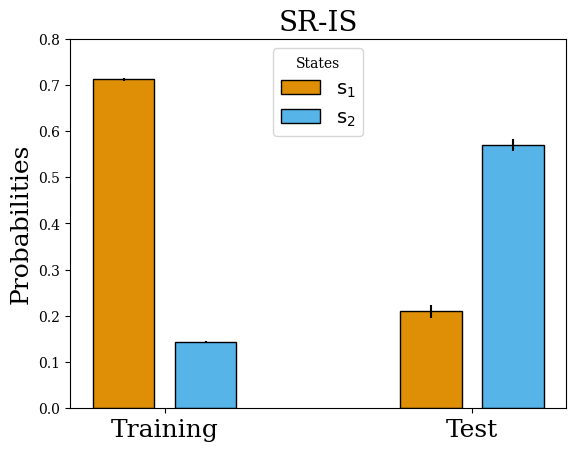

In [9]:
save_path = save_dir + 'policy_reval_sr_is.png'

prob_train_mean = [np.mean(prob_old_sr_is[0]), np.mean(prob_old_sr_is[1])]
prob_test_mean = [np.mean(prob_new_sr_is[0]), np.mean(prob_new_sr_is[1])]
std_train = [sem(prob_old_sr_is[0]), sem(prob_old_sr_is[1])]
std_test = [sem(prob_new_sr_is[0]), sem(prob_new_sr_is[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='SR-IS',
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test]
)

#### SR-MB

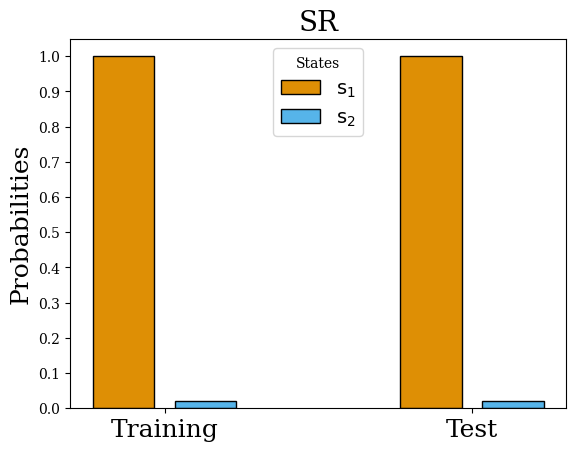

In [10]:
save_path = save_dir + 'policy_reval_sr_mb.png'

prob_train_mean = [np.mean(prob_old_sr_mb[0]), np.mean(prob_old_sr_mb[1])]
prob_test_mean = [np.mean(prob_new_sr_mb[0]), np.mean(prob_new_sr_mb[1])]
std_train = [sem(prob_old_sr_mb[0]), sem(prob_old_sr_mb[1])]
std_test = [sem(prob_new_sr_mb[0]), sem(prob_new_sr_mb[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='SR',
    leg_loc="upper center",
    save_path=save_path,
    std=[std_train, std_test]
)